Pipeline process for initial CCD processing of images. Uses the *AstroPy* coordinated package *ccdproc*.

In [1]:
## Imports copied from original pipeline, edit as seems fit.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("guide.mplstyle")

import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
from pathlib import Path
import ccdproc as ccdp
from astropy.stats import mad_std
from astropy import units as u
from matplotlib.pyplot import vlines
from matplotlib import rc, rcParams
from scipy.signal import peak_widths, find_peaks, savgol_filter
from scipy.ndimage.interpolation import rotate
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
## show_image() copied over from convenience_functions #TODO figure out imports

from astropy import visualization as aviz
from astropy.nddata.blocks import block_reduce
from astropy.nddata.utils import Cutout2D
from matplotlib import pyplot as plt


def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

In [3]:
## image display function from original pipeline, edit as seems fit.

def imshow(im):
    # - - Shows 2D image with some additional info              - - #
    # - - Parameters: im -> ndarray; 2D image stored as ndarray - - #
    # - - Returns:    nothing                                   - - #

    plt.figure(figsize = (10, 5))
    plt.imshow(im, vmax = np.mean(im) + np.std(im), vmin = np.mean(im) - np.std(im), cmap = 'gray')
    plt.title(namestr(im))
    plt.colorbar()
    
    # ^ ^ Функнция, която принтва името на променлива ^ ^ #

In [4]:
## Import raw images from directory
data_directory = "./data-cleaned"

# Include image type in header for fits - useful for filtering during
# processing. Save the modified files in a new directory called data-cleaned.

image_name_dark5s = ['DARK-5s-00{}.FIT'.format(x) for x in [1,2,3,4,5]]

for i in range(5):
    with fits.open(image_name_dark5s[i]) as hdul:
        hdr = hdul[0].header
        hdr['imagetyp'] = 'DARK'
        hdr['bunit'] = 'adu'
        hdul.writeto('data-cleaned/dark-5s-00{}.fits'.format(i+1), overwrite=True)

image_name_dark180s = ['DARK-180s-00{}.FIT'.format(x) for x in [1,2,3,4,5]]

for i in range(5):
    with fits.open(image_name_dark180s[i]) as hdul:
        hdr = hdul[0].header
        hdr['imagetyp'] = 'DARK'
        hdr['bunit'] = 'adu'
        hdul.writeto('data-cleaned/dark-180s-00{}.fits'.format(i+1), overwrite=True)

image_name_light = ['vega-180s-00{}.FIT'.format(x) for x in [1,2,3,4]]

for i in range(4):
    with fits.open(image_name_light[i]) as hdul:
        hdr = hdul[0].header
        hdr['imagetyp'] = 'LIGHT'
        hdr['bunit'] = 'adu'
        hdul.writeto('data-cleaned/vega-180s-00{}.fits'.format(i+1), overwrite=True)

image_name_calib = ['lamp2-5s-00{}.FIT'.format(x) for x in [1,2,3]]

for i in range(3):
    with fits.open(image_name_calib[i]) as hdul:
        hdr = hdul[0].header
        hdr['imagetyp'] = 'CALIB'
        hdr['bunit'] = 'adu'
        hdul.writeto('data-cleaned/lamp2-180s-00{}.fits'.format(i+1), overwrite=True)

In [5]:
# Load images in ImageFileCollection - convenient way to manage an inventory
# provided by *ccdproc*

from ccdproc import ImageFileCollection

im_collection = ImageFileCollection(data_directory)

In [7]:
# Dark combine - follow the procedure given in the *ccdproc* manual at 
# https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/03-06-Combine-darks-for-use-in-later-calibration-steps.html
calibrated_path = Path('data-reduced')
# Master dark 5s
# Select images
calibrated_darks_5s = im_collection.files_filtered(imagetyp='dark', exptime=5.0,
                                                 include_path=True)
# combine images
combined_dark_5s = ccdp.combine(calibrated_darks_5s,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )
# record master dark
combined_dark_5s.meta['combined'] = True
dark_file_name = 'combined_dark_{}s.fit'.format(5)
combined_dark_5s.write(calibrated_path / dark_file_name, overwrite=True)

# Master dark 180s
# Select images
calibrated_darks_180s = im_collection.files_filtered(imagetyp='dark', exptime=180.0,
                                                 include_path=True)
# combine images
combined_dark_180s = ccdp.combine(calibrated_darks_180s,
                             method='average',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                             mem_limit=350e6
                            )
# record master dark
combined_dark_180s.meta['combined'] = True
dark_file_name = 'combined_dark_{}s.fit'.format(180)
combined_dark_180s.write(calibrated_path / dark_file_name, overwrite=True)

INFO:astropy:splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 2 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


In [8]:
# subtract dark from science images

reduced_path = Path('data-reduced')

science_imagetyp = 'light'
exposure = 'exptime'

ifc_raw = ccdp.ImageFileCollection('data-cleaned')
ifc_reduced = ccdp.ImageFileCollection(reduced_path)

In [9]:
lights = ifc_raw.summary[ifc_raw.summary['imagetyp'] == science_imagetyp.upper()]
lights['date-obs', 'file', 'object', 'filter', exposure]

date-obs,file,object,filter,exptime
str23,str22,str1,str4,float64
2021-08-12T23:05:39.000,vega-180s-001.fits,,None,180.0
2021-08-12T23:08:42.000,vega-180s-002.fits,,None,180.0
2021-08-12T23:11:44.000,vega-180s-003.fits,,None,180.0
2021-08-12T23:14:47.000,vega-180s-004.fits,,None,180.0


In [10]:
combo_calibs = ifc_reduced.summary[ifc_reduced.summary['combined'].filled(False).astype('bool')]
combo_calibs['date-obs', 'file', 'imagetyp', 'filter', exposure]

date-obs,file,imagetyp,filter,exptime
str23,str22,str5,str4,float64
2021-08-13T01:53:25.000,combined_dark_180s.fit,DARK,None,180.0
2021-08-12T23:01:42.000,combined_dark_5s.fit,DARK,None,5.0


In [11]:
combined_darks = {ccd.header[exposure]: ccd for ccd in ifc_reduced.ccds(imagetyp='dark', combined=True)}


In [13]:
all_reds = []
light_ccds = []
for light, file_name in ifc_raw.ccds(imagetyp=science_imagetyp, return_fname=True):
    light_ccds.append(light)

    # reduced = ccdp.trim_image(light[:, :4096])
    
    # Note that the first argument in the remainder of the ccdproc calls is
    # the *reduced* image, so that the calibration steps are cumulative.
    #reduced = ccdp.subtract_bias(light, combined_bias)
    
    #closest_dark = find_nearest_dark_exposure(reduced, combined_darks.keys())

    reduced = ccdp.subtract_dark(light, combined_darks[180], 
                                 exposure_time='exptime', exposure_unit=u.second)
    
    #good_flat = combined_flats[reduced.header['filter']]
    #reduced = ccdp.flat_correct(reduced, good_flat)
    all_reds.append(reduced)
    reduced.write(reduced_path / file_name, overwrite=True)

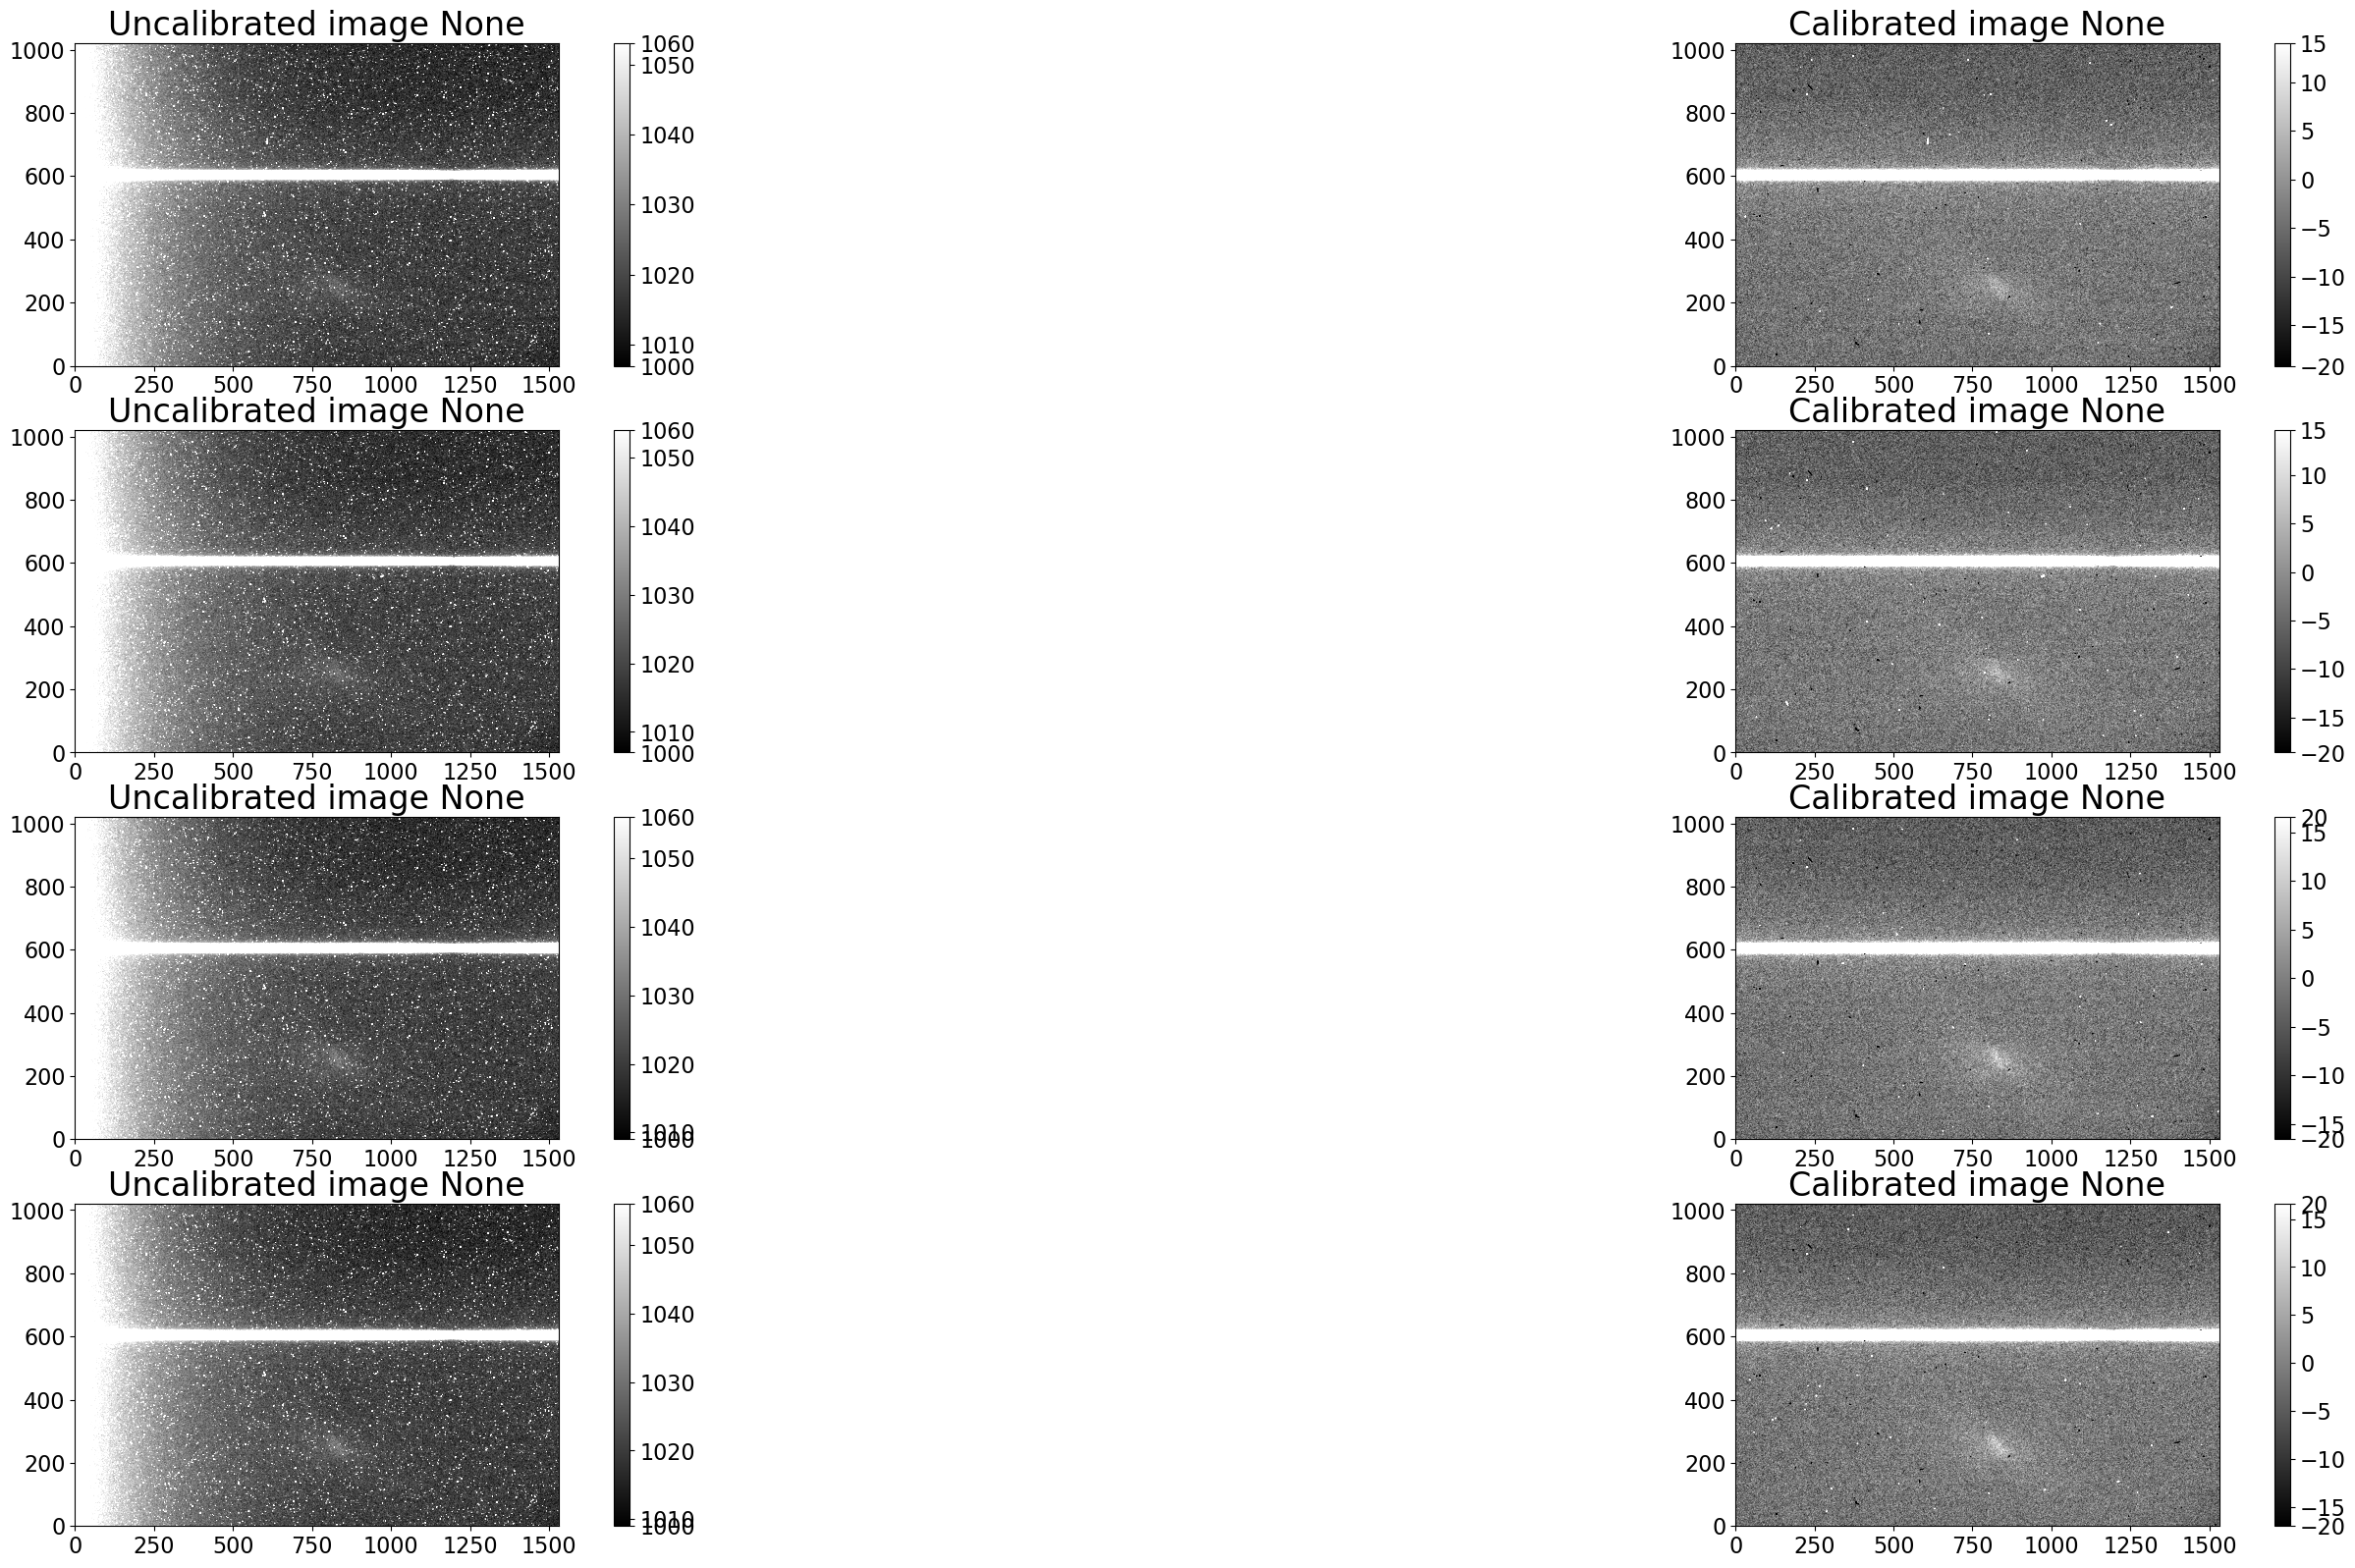

In [14]:
fig, axes = plt.subplots(4, 2, figsize=(40, 20))

for row, raw_science_image in enumerate(light_ccds):
    filt = raw_science_image.header['filter']
    axes[row, 0].set_title('Uncalibrated image {}'.format(filt))
    show_image(raw_science_image, cmap='gray', ax=axes[row, 0], fig=fig, percl=90)

    axes[row, 1].set_title('Calibrated image {}'.format(filt))
    show_image(all_reds[row].data, cmap='gray', ax=axes[row, 1], fig=fig, percl=90)